In [261]:
## Ran for eveything now with excluding the gauges that we don't want

# Create a set of dimensionless profiles
Read in all of the events, for all durations, for all gauges, for all ensemble members.  
Convert them to dimensionless profiles, with 12 values between 0 and 1.  
Each value is a dimensionless, cumulative rainfall value (cumulative rainfall at this timestep, normalised by the total event rainfall):
- 0 means no rainfall has occurred, and 
- 1 means the total event rainfall has been reached.  

If there are less than 12 values, then these are filled in with interpolation

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
import re
from datetime import datetime

quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}

from Create_Profiles_Functions import *

In [7]:
def get_normalised_intensity(array_in, len_out):
    len_in = len(array_in)
    # Calculates the total accumulated value at each original point
    # Adds a zero at the start of the array
    csum = np.cumsum(np.hstack((np.array([0.0]), array_in)))
    # Normalise accumulation to 0 to 1
    csum = csum / csum[-1]
    # Array going from 0 up to 1: normalised time
    # corresponding to these points
    normalised_time_in = np.arange(len_in + 1) / (1.0 * len_in)
    # Array of the "time points" corresponding to
    # Boundaries of output intervals
    normalised_time_out = np.arange(len_out + 1) / (1.0 * len_out)
    # Interpolate total accumulated value to desired output points
    csum_out = np.interp(normalised_time_out, normalised_time_in, csum)
    # Interpolate back to accumulations over the desired number of intervals
    # Scale with the number of points to normalise
    normalised_intensity = (csum_out[1:] - csum_out[:-1]) * len_out
    return normalised_intensity

def analyse_event(array_in):
    # Remove leading/trailing zeros from array
    # can we always do this?
    trimmed_array = np.trim_zeros(array_in)
    # Go from raw data directly to 12 and 5 points
    event_curve_12 = get_normalised_intensity(trimmed_array, 12)
    event_curve_12 = np.append([0], event_curve_12)
    event_curve_12 = np.append(event_curve_12, [0])    
    
    event_curve_5 = get_normalised_intensity(trimmed_array, 5)
    # Get the category as a number from 1 to 5
    # add 1 as python indexing starts at 0
    category = np.argmax(event_curve_5) + 1
    return category, event_curve_12


In [8]:
def interpolate_rainfall(rainfall, bin_number):
    if rainfall is None or len(rainfall) < 2:
        return None

    # Define target points for bin_number bins
    target_points = np.linspace(0, 1, bin_number+1)
    
    # Create interpolation function based on existing data points
    rainfall_times = np.array(range(0, len(rainfall)))

    # Normalize time from 0 to 1
    normalized_time = (rainfall_times - rainfall_times[0]) / (rainfall_times[-1] - rainfall_times[0])
    interpolation_func = interp1d(normalized_time, rainfall, kind='linear', fill_value="extrapolate")
    
    # Interpolate values at target points
    interpolated_values = interpolation_func(target_points)
    
    return interpolated_values, target_points

def create_cumulative_event(rainfall, interval=0.5):
    if rainfall is None:
        return None, None
    
    # Calculate cumulative rainfall
    cumulative_rainfall = np.cumsum(rainfall)
    cumulative_rainfall = [0] + cumulative_rainfall
    
    # Generate corresponding time points
    time_points = np.arange(0, len(rainfall) + 1) * interval
    
    return  [0] + cumulative_rainfall.tolist(), time_points.tolist()

def create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times):

    # Step 3: Normalize the cumulative rainfall by the total event depth
    total_event_depth = cumulative_rainfall[-1]
    normalized_cumulative_rainfall = np.array(cumulative_rainfall) / total_event_depth

    total_event_time = cumulative_rainfall_times[-1]
    normalized_cumulative_rainfall_times = np.array(cumulative_rainfall_times) / total_event_time
    normalized_cumulative_rainfall_times
    
    return normalized_cumulative_rainfall, normalized_cumulative_rainfall_times


def find_intensity_as_proportion_of_mean_event(incremental_rainfall):
    mean_over_event = np.mean(incremental_rainfall)
    irain = incremental_rainfall/np.mean(incremental_rainfall)
    return irain


def create_incremental_event(cumulative_rainfall):
    if cumulative_rainfall is None :
        return None
    raw_rainfall = np.diff(cumulative_rainfall, prepend=0)
    return raw_rainfall[1:]


def find_max_quintile (precip):
    if precip is None:
        return None
    else:
        cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(precip)
        dimensionless_cumulative_rainfall, dimensionless_times =  create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
        interpolated5_cumulative_rainfall, interpolated5_times = interpolate_rainfall(dimensionless_cumulative_rainfall,5)
        interpolated5_incremental_rainfall = create_incremental_event(interpolated5_cumulative_rainfall)
        max_quintile_profile_5 = find_part_with_most_rain(interpolated5_incremental_rainfall, 5)
        return max_quintile_profile_5
    
def create_irain_profile(precip, bins =12 ):
    cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(precip)
    dimensionless_cumulative_rainfall, dimensionless_times =  create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
    interpolated_cumulative_rainfall, interpolated_times = interpolate_rainfall(dimensionless_cumulative_rainfall,bins)
    interpolated_incremental_rainfall = create_incremental_event(interpolated_cumulative_rainfall)

    irain = find_intensity_as_proportion_of_mean_event(interpolated_incremental_rainfall)
    irain = np.append([0], irain)
    irain = np.append(irain, [0])    
    
    len_intensity = len(irain)
    # Time points: start of event, end of event, midpoint of the intervals
    times = np.hstack((np.array([0.0]),
            (np.arange(len_intensity) + 0.5) / len_intensity,
            np.array([1.0])))
    
    return irain

In [9]:
gauge_nums = range(0,1294)

# UKCP18
### Make and pickle profiles

In [10]:
def create_dataframe_row(this_event):
    # Trim the event and remove problematic events
    trimmed_event = remove_leading_and_trailing_zeroes(this_event)
    real_trimmed_event, problem_events = remove_events_with_problems(trimmed_event, verbose=False)
    
    if real_trimmed_event is None:
        return {
        'precip':None,
        'times': None,
        "season" : get_season(trimmed_event['times'][0]),
        'duration':None,
        "year":extract_year(trimmed_event),
        'Volume': None,
    }
    
    # Return only the relevant data in a dictionary
    return {
        'precip': real_trimmed_event['precipitation (mm)'].values,
        'times': trimmed_event['times'].values,
        "season" : get_season(trimmed_event['times'][0]),
        'duration':len(real_trimmed_event) / 2,
        "year":extract_year(trimmed_event),
        'Volume': sum(real_trimmed_event['precipitation (mm)'].values),
    }

# Initialize an empty list to collect rows
rows = []

for em in ["bc009"]:
    for gauge_num in range(0, 1293):
        if gauge_num not in [444, 827, 888]:
            if gauge_num % 100 == 0:
                print(f"Processing gauge {gauge_num}")
            
            files = [f for f in os.listdir(f"/nfs/a161/gy17m2a/PhD/ProcessedData/IndependentEvents/UKCP18_30mins/Present/{em}/{gauge_num}/WholeYear/") if f.endswith('.csv')]
            files = np.sort(files)

            for file in files:
                fp = f"/nfs/a161/gy17m2a/PhD/ProcessedData/IndependentEvents/UKCP18_30mins/Present/{em}/{gauge_num}/WholeYear/{file}"
                if '2080' in fp:
                    continue

                this_event = read_event(gauge_num, fp)

                # Create the row data with just 'precip' and 'times'
                row_data = create_dataframe_row(this_event)
                
                # Only append rows that are not None
                if row_data is not None:
                    rows.append(row_data)

# Create DataFrame from collected rows
df = pd.DataFrame(rows)

Processing gauge 0
Processing gauge 100
Processing gauge 200
Processing gauge 300
Processing gauge 400
Processing gauge 500
Processing gauge 600
Processing gauge 700
Processing gauge 800
Processing gauge 900
Processing gauge 1000
Processing gauge 1100
Processing gauge 1200


In [16]:
with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/UKCP18_30mins/Present/{em}/df.pkl", 'wb') as file:
    pickle.dump(df, file)

### Create version without Nones

In [17]:
df_withoutnulls = df[df['precip'].notnull()].copy()

### Add quintile categorisations

In [18]:
df_withoutnulls['max_quintile_molly'] = df_withoutnulls['precip'].apply(find_max_quintile)
df_withoutnulls['max_quintile_steef'] = df_withoutnulls['precip'].apply(analyse_event)
df_withoutnulls['max_quintile_raw_rain'] = df_withoutnulls['precip'].apply(lambda x: find_part_with_most_rain(x, 5))
df_withoutnulls[['max_quintile_steef', 'irain_profile_12_Steef']] = df_withoutnulls['precip'].apply(lambda x: pd.Series(analyse_event(x)))

### Add loading categories

In [21]:
df_withoutnulls['Loading_profile_raw_rain'] = df_withoutnulls['max_quintile_raw_rain'].map(quintile_mapping)
df_withoutnulls['Loading_profile_molly'] =df_withoutnulls['max_quintile_molly'].map(quintile_mapping)
df_withoutnulls['Loading_profile_steef'] =df_withoutnulls['max_quintile_steef'].map(quintile_mapping)

### Add profiles

In [19]:
df_withoutnulls['irain_profile_12'] = df_withoutnulls['precip'].apply(lambda x: create_irain_profile(x, 12))

In [59]:
# df_withoutnulls[df_withoutnulls['max_quintile_molly']!=df_withoutnulls['max_quintile_steef']]

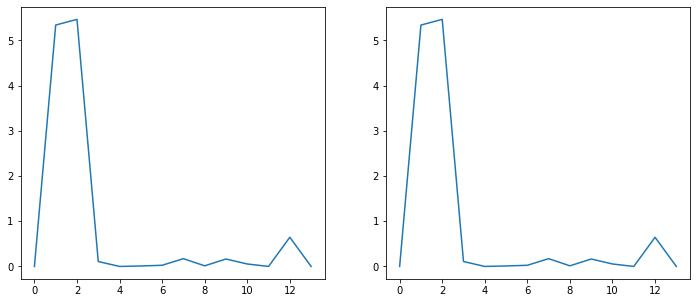

In [52]:
# fig,axs=plt.subplots(ncols=2, figsize=(12,5))
# axs[0].plot(df_withoutnulls['irain_profile_12_Steef'][0])
# axs[1].plot(df_withoutnulls['irain_profile_12'][0])

In [23]:
with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/UKCP18_30mins/Present/{em}/df_withoutnulls.pkl", 'wb') as file:
    pickle.dump(df_withoutnulls, file)